# 🩺 Predikcija dijabetesa – odbrana projekta

**Autor:** _Milica Bosančić SV60/2022_

**Predmet:** Računarske inteligencije


## 1️⃣ Postavljanje okruženja
Kratki importi i postavljanje seed-a radi reproduktivnosti.

In [1]:
import os, json, numpy as np
from src.utils import prepare_dataset, class_balance, FEATURES
from src.train_eval import train_and_evaluate_all
from src.plotting import generate_all_plots
from src.infer import predict_single

np.random.seed(42)
DATA_CSV = 'data/diabetes.csv'
OUT_DIR = 'outputs'
print('OK: imports ready')

OK: imports ready


## 2️⃣ Kratki pregled skupa podataka
- Pima Indians Diabetes dataset
- Stratifikovan split 70/15/15
- Zero→NaN u medicinski relevantnim kolonama
- Median imput + standardizacija po train-u

Napomena: obrada je implementirana u `src/utils.py`.

In [2]:
ds = prepare_dataset(DATA_CSV, seed=42)
print('Oblici (train/val/test):', ds.X_train.shape, ds.X_val.shape, ds.X_test.shape)
print('Balans klasa (train):', class_balance(ds.y_train))
print('Feature kolone:', FEATURES)

Oblici (train/val/test): (536, 8) (115, 8) (116, 8)
Balans klasa (train): {0: 0.6511194029850746, 1: 0.34888059701492535}
Feature kolone: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


## 3️⃣ Treniranje i evaluacija modela
Treniramo četiri modela (Naive Bayes, KNN, Logistic Regression, MLP). Prag (threshold) se bira na **validacionom** skupu maksimizacijom **F1**; izveštavamo metrike na **test** skupu.

Izlaz: `outputs/summary.json` i `outputs/summary.csv` + per-model fajlovi.

In [3]:
results = train_and_evaluate_all(csv_path=DATA_CSV, out_dir=OUT_DIR, seed=42)
with open(os.path.join(OUT_DIR, 'summary.json'), 'r', encoding='utf-8') as f:
    summary = json.load(f)
summary

[{'model': 'NaiveBayes',
  'threshold': 0.1720510351533513,
  'val_f1': 0.723404255319149,
  'val_auc': 0.8396666666666666,
  'val_ap': 0.6768147630658893,
  'test_f1': 0.6,
  'test_auc': 0.7697368421052632,
  'test_ap': 0.6297567482280795},
 {'model': 'KNN',
  'threshold': 0.4,
  'val_f1': 0.6938775510204082,
  'val_auc': 0.8009999999999999,
  'val_ap': 0.5919111846692933,
  'test_f1': 0.6875000000000001,
  'test_auc': 0.8274671052631579,
  'test_ap': 0.6764943314398849},
 {'model': 'LogReg',
  'threshold': 0.22970082880704762,
  'val_f1': 0.7676767676767676,
  'val_auc': 0.8673333333333333,
  'val_ap': 0.7441858776113951,
  'test_f1': 0.5981308411214953,
  'test_auc': 0.7848684210526317,
  'test_ap': 0.6620165883272728},
 {'model': 'MLP',
  'threshold': 0.07665251981401257,
  'val_f1': 0.6391752577319588,
  'val_auc': 0.7366666666666667,
  'val_ap': 0.6155555992848495,
  'test_f1': 0.5617977528089888,
  'test_auc': 0.7266447368421052,
  'test_ap': 0.6170189787657364}]

## 4️⃣ Tabela rezultata (val/test)
Kratak pregled ključnih metrika po modelu.

In [4]:
from pprint import pprint
def fmt(x):
    return '-' if x is None else (f'{x:.3f}' if isinstance(x,(int,float)) else str(x))
headers = ['Model','Thr','Val F1','Val AUC','Val AP','Test F1','Test AUC','Test AP']
rows = []
for s in summary:
    rows.append([
        s['model'],
        fmt(s['threshold']), fmt(s['val_f1']), fmt(s['val_auc']), fmt(s['val_ap']),
        fmt(s['test_f1']), fmt(s['test_auc']), fmt(s['test_ap'])
    ])
colw = [max(len(h), max(len(str(r[i])) for r in rows)) for i,h in enumerate(headers)]
line = '+' + '+'.join(['-'*(w+2) for w in colw]) + '+'
print(line)
print('|'+'|'.join([' '+headers[i].ljust(colw[i])+' ' for i in range(len(headers))])+'|')
print(line)
for r in rows:
    print('|'+'|'.join([' '+str(r[i]).ljust(colw[i])+' ' for i in range(len(headers))])+'|')
print(line)
# Najbolji po Test F1, tie-break AUC
best = None
for s in summary:
    if best is None or (s['test_f1']>best['test_f1']) or (abs(s['test_f1']-best['test_f1'])<1e-9 and s['test_auc']>best['test_auc']):
        best = s
print('\n🏆 Best model:', best['model'], f"(test F1={fmt(best['test_f1'])}, AUC={fmt(best['test_auc'])}, AP={fmt(best['test_ap'])})")

+------------+-------+--------+---------+--------+---------+----------+---------+
| Model      | Thr   | Val F1 | Val AUC | Val AP | Test F1 | Test AUC | Test AP |
+------------+-------+--------+---------+--------+---------+----------+---------+
| NaiveBayes | 0.172 | 0.723  | 0.840   | 0.677  | 0.600   | 0.770    | 0.630   |
| KNN        | 0.400 | 0.694  | 0.801   | 0.592  | 0.688   | 0.827    | 0.676   |
| LogReg     | 0.230 | 0.768  | 0.867   | 0.744  | 0.598   | 0.785    | 0.662   |
| MLP        | 0.077 | 0.639  | 0.737   | 0.616  | 0.562   | 0.727    | 0.617   |
+------------+-------+--------+---------+--------+---------+----------+---------+

🏆 Best model: KNN (test F1=0.688, AUC=0.827, AP=0.676)


## 5️⃣ Grafici (ROC / Precision–Recall / konfuzione matrice)
Generišemo grafikone i prikažemo ih iz `outputs/`.

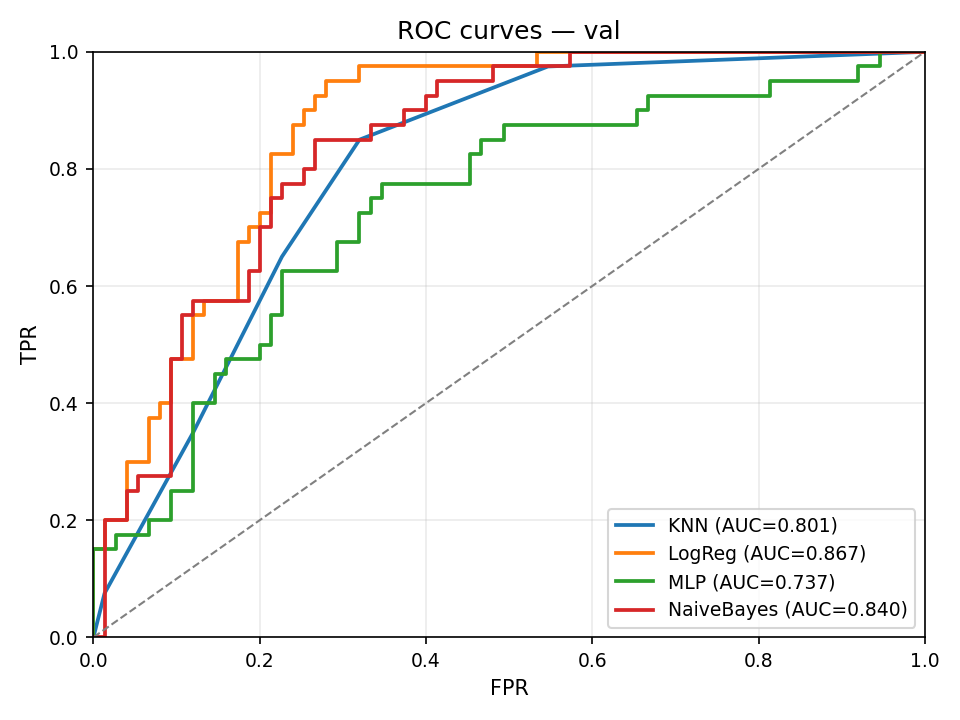

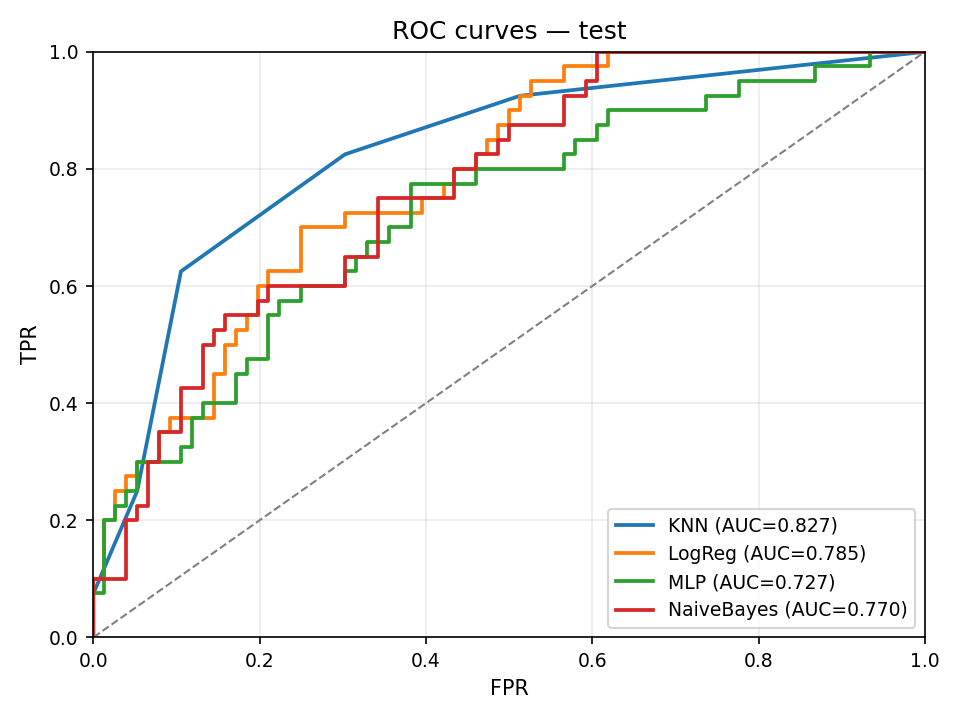

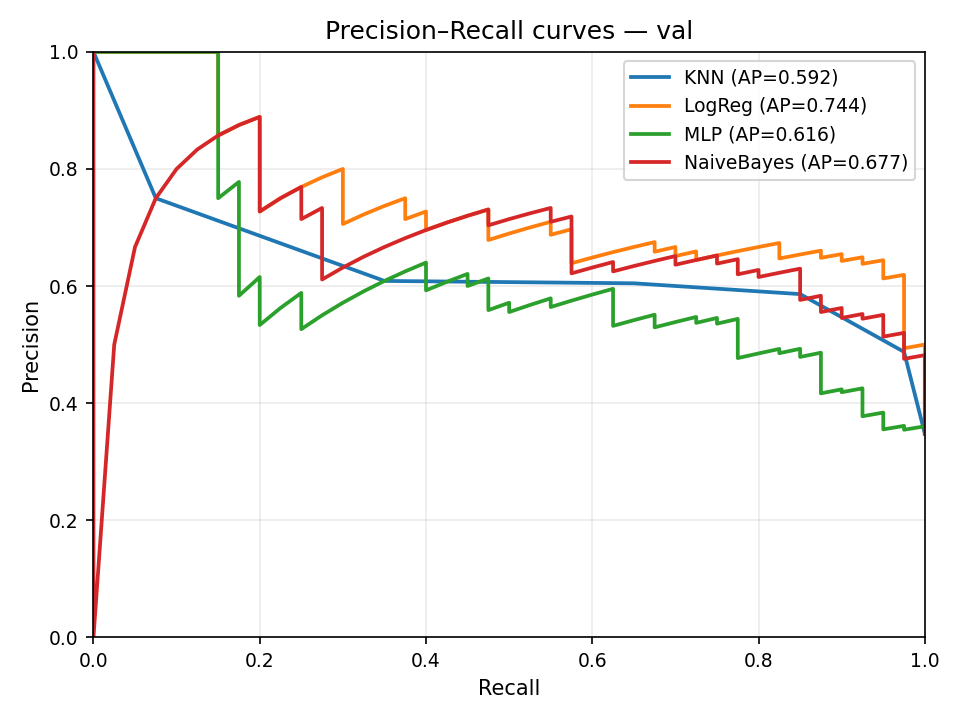

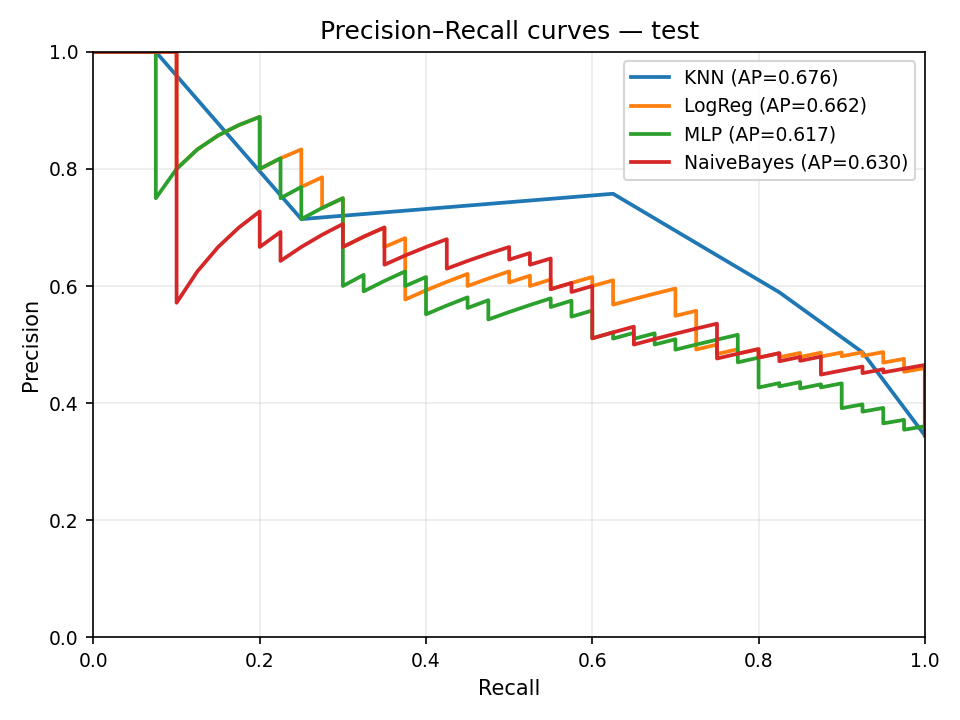

In [5]:
generate_all_plots(outputs_dir=OUT_DIR)
import IPython.display as disp
for fn in ['ROC_curves_val.png','ROC_curves_test.png','Precision–Recall_curves_val.png','Precision–Recall_curves_test.png']:
    p = os.path.join(OUT_DIR, fn)
    if os.path.isfile(p):
        display(disp.Image(filename=p))

## 6️⃣ Konfuzione matrice (test)
Po modelu, ispisi slike generisane tokom evaluacije.

In [8]:
for s in summary:
    name = s['model']
    path = os.path.join(OUT_DIR, name, 'test_confusion_matrix.png')
    if os.path.isfile(path):
        from IPython.display import Image, display
        print(f'\n{name}')
        display(Image(filename=path))

## 7️⃣ Demo: unos jednog pacijenta i odluka modela
Primer kako korisnik može uneti svoje podatke i dobiti procenu rizika. Model/family se bira na osnovu najboljeg iz `summary.json` (može se fiksirati i ručno).

In [9]:
example = {
    'Pregnancies': 2,
    'Glucose': 130,
    'BloodPressure': 72,
    'SkinThickness': 35,
    'Insulin': 100,
    'BMI': 30.5,
    'DiabetesPedigreeFunction': 0.45,
    'Age': 35,
}
res = predict_single(example, csv_path=DATA_CSV, outputs_dir=OUT_DIR, family=None)
label = 'POVIŠEN RIZIK' if res['label']==1 else 'nema povišen rizik'
print('Model:', res['family'])
print('Threshold:', f"{res['threshold']:.4f}")
print('Score:', f"{res['score']:.4f}")
print('Decision:', label)

Model: KNN
Threshold: 0.2857
Score: 0.2857
Decision: POVIŠEN RIZIK


## 8️⃣ Zaključak
- Najbolji model prema **test F1** (tie-break AUC) je prikazan gore.
- ROC i PR krive potvrđuju sposobnost razdvajanja klasa.
- Threshold je biran na validacionom skupu maksimizacijom F1.

**Ograničenja:** dataset je mali i klasa 1 je ređa; accuracy nije najbolja metrika → koristimo F1/Recall.